In [151]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [152]:
images_path = "/Users/ciro/Documents/dataset"
masks_path = "/Users/ciro/Documents/dataset"

In [153]:
 
import random

limit=40
images = []
masks = [] 
 


 
def get_images(grade):
    grade_dir = os.path.join(images_path, grade)
    
    # List all files in the grade_dir and filter out .DS_Store
    all_files = [imgname for imgname in os.listdir(grade_dir) if imgname != ".DS_Store"]
    
    # Randomly sample 20 files from the list
    sampled_files = random.sample(all_files, min(limit, len(all_files)))
    
    for imgname in sampled_files:
        modalities = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        file_paths = [os.path.join(grade_dir, imgname, f"{imgname}{modality}") for modality in modalities]
        images.append(file_paths)

 
 

def get_masks(grade):
    grade_dir = os.path.join(masks_path, grade)
    
    # List all files in the grade_dir and filter out .DS_Store
    all_files = [imgname for imgname in os.listdir(grade_dir) if imgname != ".DS_Store"]
    
    # Randomly sample 20 files from the list
    sampled_files = random.sample(all_files, min(limit, len(all_files)))
    
    for imgname in sampled_files:
        file_name = f"{imgname}_seg.nii"
        file_path = os.path.join(grade_dir, imgname, file_name)
        masks.append(file_path)
        
get_images('HGG')
get_images('LGG')
get_masks('HGG')
get_masks('LGG')

print("Number of image sets loaded:", len(images))
print("Number of masks loaded:", len(masks))


Number of image sets loaded: 80
Number of masks loaded: 80


In [154]:
images_paths.sort()
masks_paths.sort()

In [159]:
from skimage.transform import resize

def load_and_slice_multimodal_image(image_paths, mask_path, target_shape=(128, 128)):
    images = [nib.load(img_path).get_fdata() for img_path in image_paths]
    mask = nib.load(mask_path).get_fdata()
    
    slices_img = []
    slices_mask = []
    
    for i in range(images[0].shape[2]):
        slice_imgs = [resize(img[:,:, i], target_shape, mode='constant', preserve_range=True) for img in images]
        slice_img = np.stack(slice_imgs, axis=-1)
        slice_mask = resize(mask[:, :, i], target_shape, mode='constant', preserve_range=True, order=0)
        
        slices_img.append(slice_img)
        slices_mask.append(slice_mask)
    
    return np.array(slices_img), np.array(slices_mask)

# Load and slice images and masks
all_slices_img = []
all_slices_mask = []

for img_paths, mask_path in zip(images, masks):
    slices_img, slices_mask = load_and_slice_multimodal_image(img_paths, mask_path)
    all_slices_img.extend(slices_img)
    all_slices_mask.extend(slices_mask)

all_slices_img = np.array(all_slices_img)
all_slices_mask = np.expand_dims(np.array(all_slices_mask), axis=-1)

print("Total slices of images:", all_slices_img.shape)
print("Total slices of masks:", all_slices_mask.shape)


Total slices of images: (12400, 128, 128, 4)
Total slices of masks: (12400, 128, 128, 1)


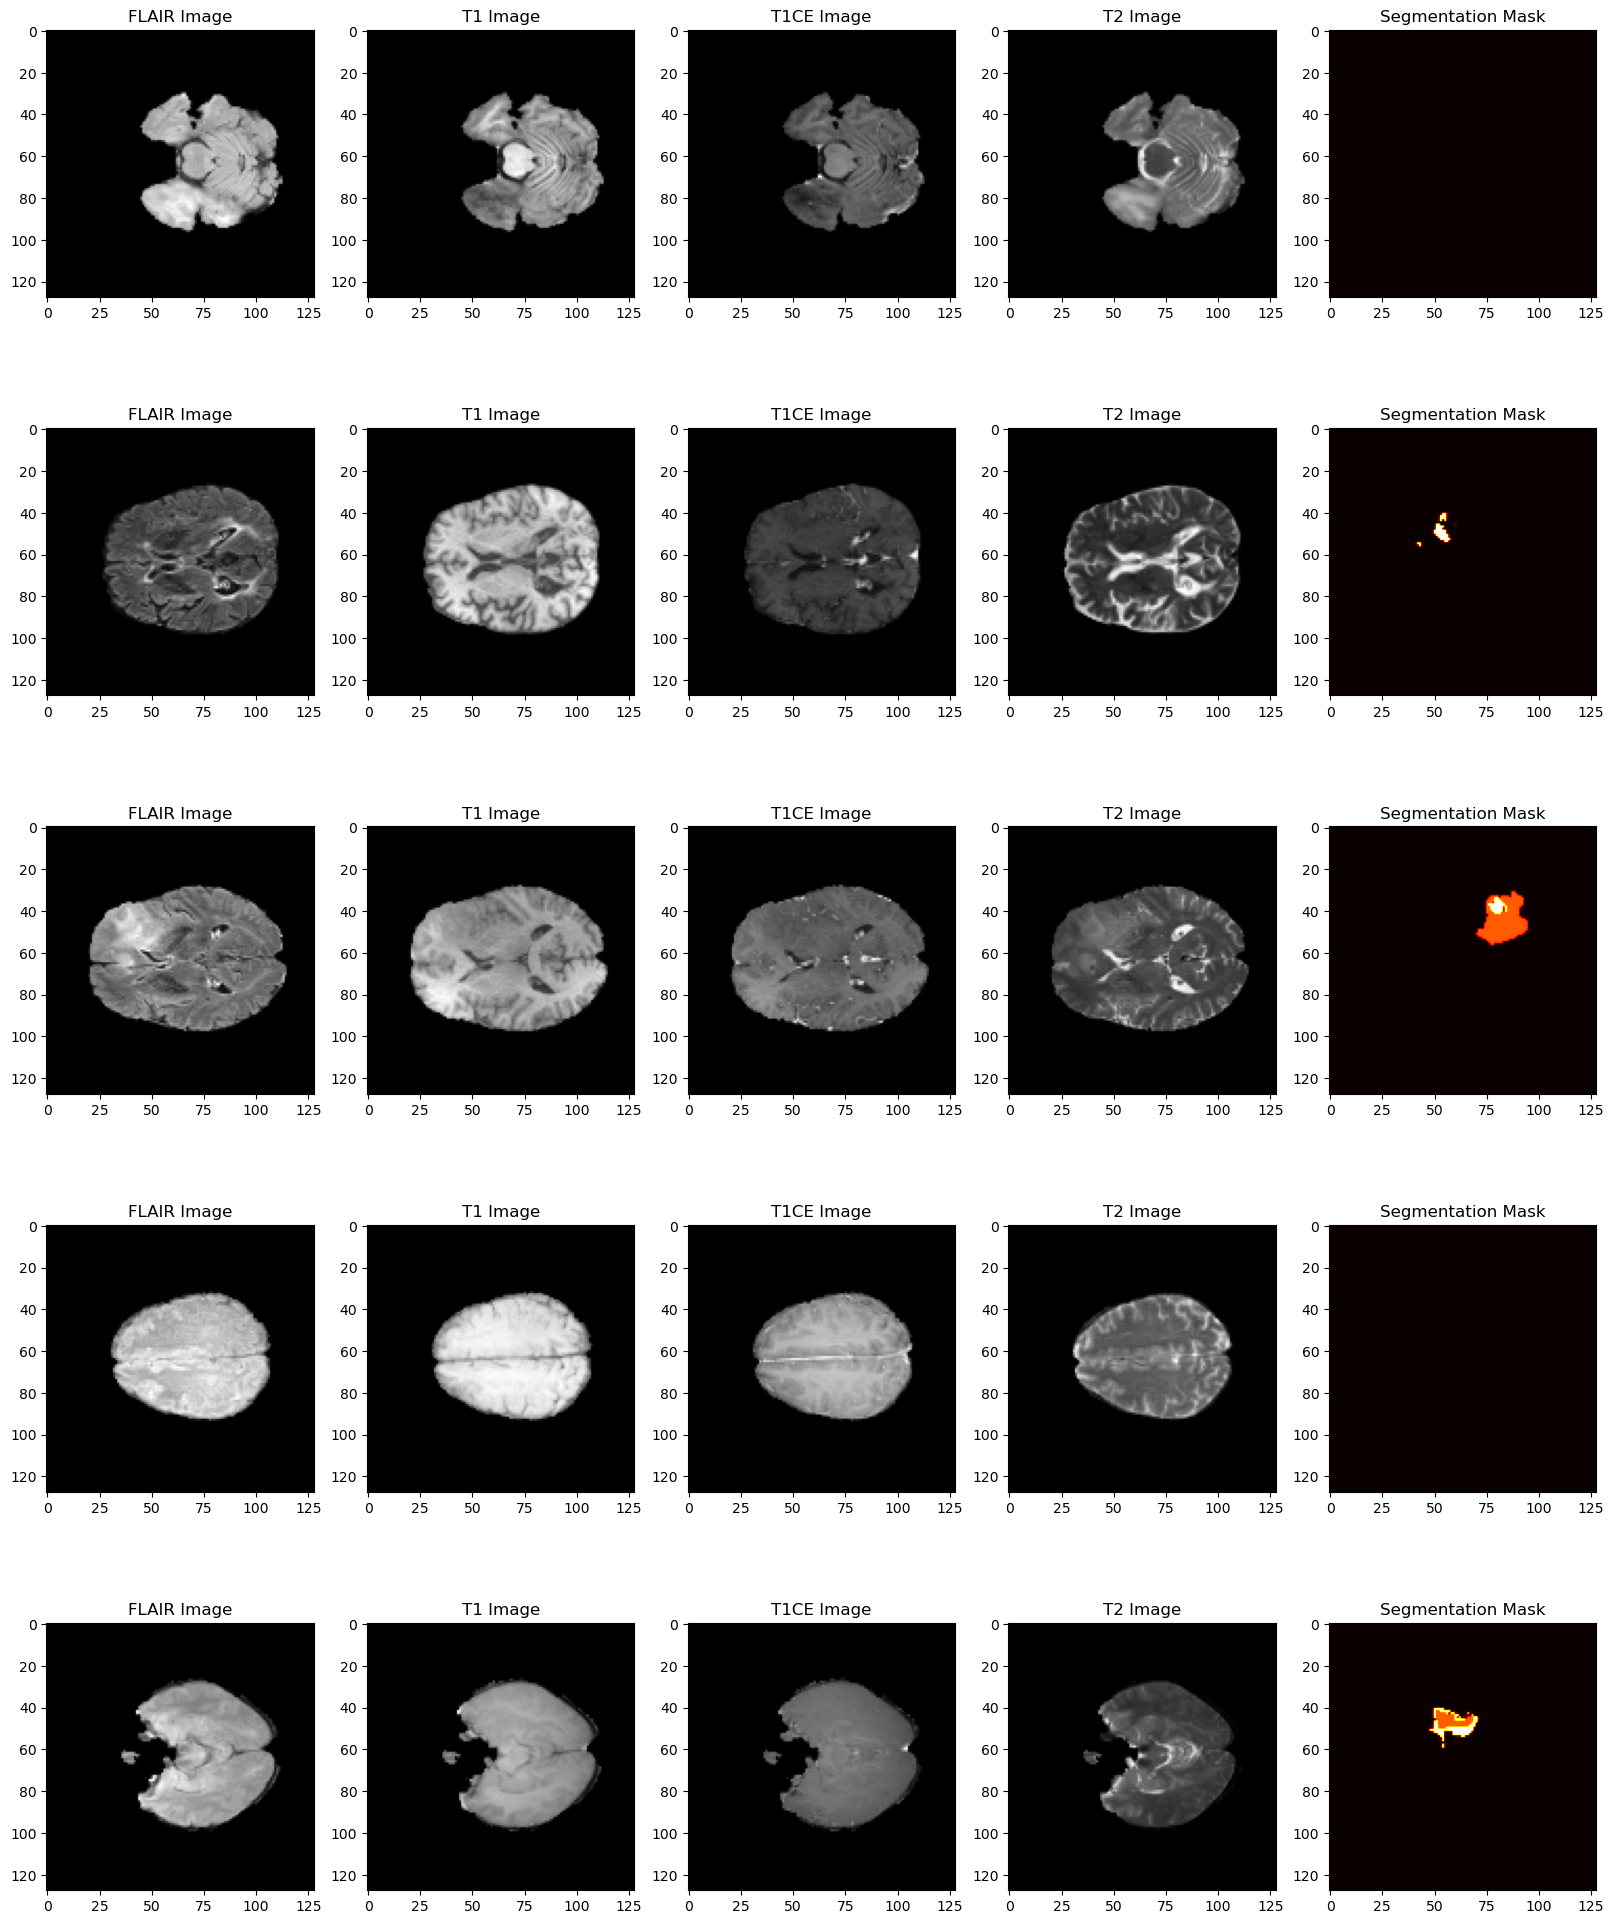

In [169]:


def visualize_multimodal_slices(images, masks, num_samples=5):
    modalities = ['FLAIR', 'T1', 'T1CE', 'T2']
    plt.figure(figsize=(20, num_samples * 5))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        for j in range(4):
            plt.subplot(num_samples, 5, 5 * i + j + 1)
            plt.imshow(images[idx][:, :, j], cmap='gray')
            plt.title(f'{modalities[j]} Image')
        
        plt.subplot(num_samples, 5, 5 * i + 5)
        plt.imshow(masks[idx].squeeze(), cmap='hot')
        plt.title('Segmentation Mask')
    
    plt.show()

visualize_multimodal_slices(all_slices_img, all_slices_mask)


    
    


In [170]:

# Check the shapes of the data
print("Shape of all_slices_img:", all_slices_img.shape)
print("Shape of all_slices_mask:", all_slices_mask.shape)

# Ensure the data type is float32
all_slices_img = all_slices_img.astype(np.float32)
all_slices_mask = all_slices_mask.astype(np.float32)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_slices_img, all_slices_mask, test_size=0.2, random_state=42)

# Define the U-Net model
def unet_model(input_size=(128, 128, 4)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


Shape of all_slices_img: (12400, 128, 128, 4)
Shape of all_slices_mask: (12400, 128, 128, 1)


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6967s 6s/step - accuracy: 0.9718 - loss: 1.1008 - val_accuracy: 0.9839 - val_loss: 0.0693
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6722s 5s/step - accuracy: 0.9835 - loss: 0.0631 - val_accuracy: 0.9839 - val_loss: 0.0583
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 26501s 21s/step - accuracy: 0.9837 - loss: 0.0586 - val_accuracy: 0.9809 - val_loss: 0.0567
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3705s 3s/step - accuracy: 0.9826 - loss: 0.0608 - val_accuracy: 0.9839 - val_loss: 0.0705
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3673s 3s/step - accuracy: 0.9840 - loss: 0.0710 - val_accuracy: 0.9839 - val_loss: 0.0692
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3584s 3s/step - accuracy: 0.9833 - loss: 0.0705 - val_accuracy: 0.9839 - val_loss: 0.0690
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3599s 3s/step - accuracy: 0.9838 - loss: 0.0694 - val_accuracy: 0.9839 - val_loss: 0.0689
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3597s 3s/step - accuracy: 0.9839

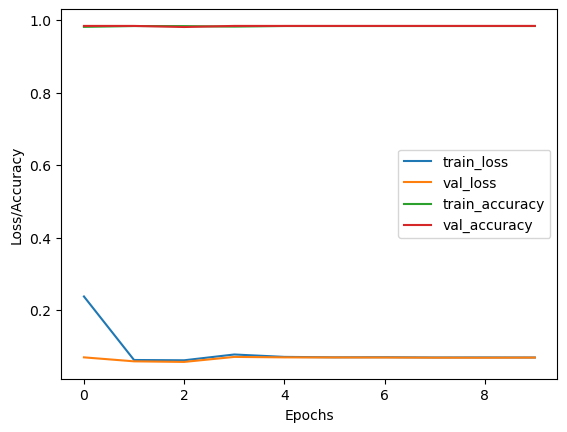

In [172]:

# Initialize the model
model = unet_model()

# Define callbacks
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8, callbacks=[checkpoint, early_stopping])

# Plotting training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

78/78 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step


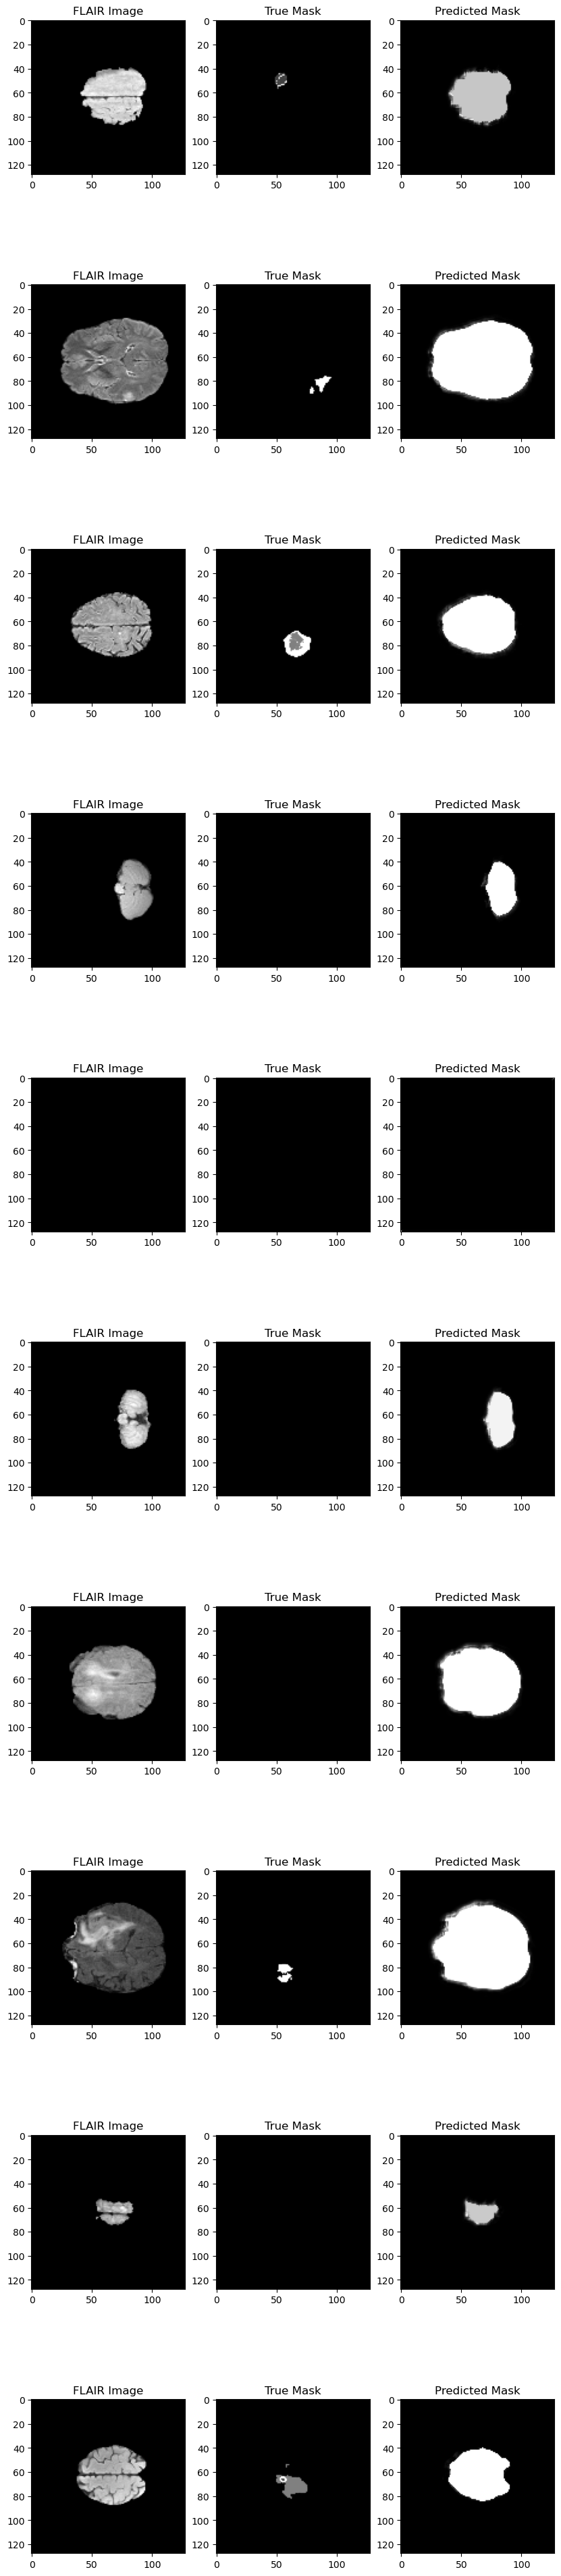

In [176]:
def show_results(model, images, masks, num_samples=10):
    predictions = model.predict(images)
    
    plt.figure(figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[idx][:, :, 0], cmap='gray')  # Displaying one of the modalities (e.g., FLAIR)
        plt.title('FLAIR Image')
        
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.show()

show_results(model, X_val, y_val)


In [177]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save('Unet_model_with_80_images_sliced_i.keras')
